#### Supply Chain Analytics Exploratory
### by Victor Gafton

Objective: Business Understanding and extracting information from customer briefing  
Technical: Combine multiple data sources, perform Exploratory Data Analysis   
Mathematical: Calculate descriptive statistics  

A Muesli distribution company has approached me to help them understand their delivery process. They want to develop KPIs to help them keep track of the health of their business in order to improve the service they offer their customers.

The warehouse manager described the workflow as follows:
Order received (Day 1) - order processed in warehouse and made ready to ship (normally 2 days) - order leaves warehouse in truck following day - order delivered to customer (handled by logistics company).

The company has provided a list of their transactions over the course of the past years. They have full data on Order Date and the ‘On Truck Scan’ date but have limited visibility of what happens in between. They have on occasion sent some interns into the warehouse to record the ‘Ready to Ship’ date for as many orders as they could. The warehouse manager says they have not changed their processes much in the past year so they think it should be a good estimate. 

Customers can send orders every day but the warehouse only works Monday to Friday so any orders received on the weekends wait until Monday to be actioned.

Trucks Leave the warehouse on Mondays, Wednesdays and Fridays.
Orders leave on trucks the day after they are made ready for shipping (or two days later if there is no truck).
Customers can pay for Express Processing that means the orders leave on the truck the day the order is ready for shipping.

The logistics company has said they have on average 3 day delivery times to all locations. They transport goods on weekends but only deliver to customers from their local distribution centers on weekdays. The Muesli company has some data about exact delivery dates for a number of shipments that was gathered via marketing promotions they ran where customers scanned a QR code on the package in order to register for a prize. (We assume customers always scanned the code on the day of arrival).

The company would like to know how long an order would take to be delivered to the customer depending on what day it is received. They would like to know the average as well as 95th percentile of deliveries (i.e. the number of days under which 95% of orders will be delivered). Consider building a new dataset that is made up of ‘simulated’ data that is randomly selected from the partial datasets that are available in order to create a set of simulated orders that can be measured to show the distribution of delivery times. 

## 1. Mapping out the order process in a flow chart. 

In [ ]:
![](Flowchart.png)

## 2. Invent some KPIs that would be useful for tracking the performance processes overall and at each stage.

a. Outcome: Company Profit per Year
b. Outcome: Ship Mode Profit per Year
c. Internal Process: Check Average Time for each Ship Mode per Day of Week 
d. External Process: Check Average Delivery Time of the Logistic Company
e. Internal Process: Impact of Day of the Order on Delivery Time


## 3. Explore the Datasets
Before beginning the analysis, I will load and view the datasets and perform some initial cleaning.

In [1]:
# load libraries

import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

#turn off warnings for final notebook

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Floats (decimal numbers) should be displayed rounded with 2 decimal places
pd.options.display.float_format = "{:,.2f}".format
# Set style for plots
plt.style.use('fivethirtyeight') 

In [3]:
# load datasets

df_orders = pd.read_excel("data/Muesli Project raw data.xlsx", sheet_name='Orders', header=1)
df_campaign = pd.read_excel("data/Muesli Project raw data.xlsx", sheet_name='Campaign Data')
df_process = pd.read_excel("data/Muesli Project raw data.xlsx", sheet_name='Order Process Data')
df_intern = pd.read_excel("data/Muesli Project raw data.xlsx", sheet_name='InternData Study')

In [4]:
df_orders.head(1)

,Index,Order ID,Order Date,Ship Mode,Customer ID,Customer Name,Origin Channel,Country/Region,City,State,Postal Code,Region,Category,Sub-Category,Product ID,Sales,Quantity,Discount,Profit
0,27.00,CA-2019-121755,2019-01-16,Second Class,EH-13945,Eric Hoffmann,Email,United States,Los Angeles,California,"90,049.00",West,Special Projects Muesil,Gluten Free,TEC-AC-10003027,90.57,3.00,0.00,11.77


In [5]:
df_campaign.head(1)

,Order ID,Arrival Scan Date,Customer Name
0,CA-2019-109666,2019-05-03,Kunst Miller


In [6]:
df_process.head(1)

,Row ID,Order ID,Order Date,On Truck Scan Date,Ship Mode
0,"3,074.00",CA-2019-125206,2019-01-03,2019-01-07,Express


In [7]:
df_intern.head(1)

,Order ID,Ready to Ship Date,Pickup Date
0,CA-2019-116540,2019-09-02,2019-09-03


In [8]:
    # drop columns we don't need
    df_orders.drop(["Index", "City", "State", "Postal Code","Origin Channel", "Country/Region", "Region", "Category", "Sub-Category","Product ID", "Quantity", "Discount"], axis=1, inplace=True)
    # extract year/day of week information out of column order_date and build new column. 0 = Monday and 6 = Sunday.
    df_orders["order_year"]=df_orders["Order Date"].dt.year
    df_orders["order_weekday"]=df_orders["Order Date"].dt.dayofweek
    df_process["order_weekday"]=df_process["Order Date"].dt.dayofweek
    df_process["truck_weekday"]=df_process["On Truck Scan Date"].dt.dayofweek

In [9]:
# We now want to check out our data-types as well as get a feeling for possible missing values
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order ID       9994 non-null   object        
 1   Order Date     9994 non-null   datetime64[ns]
 2   Ship Mode      9994 non-null   object        
 3   Customer ID    9994 non-null   object        
 4   Customer Name  9994 non-null   object        
 5   Sales          9994 non-null   float64       
 6   Profit         9994 non-null   float64       
 7   order_year     9994 non-null   int64         
 8   order_weekday  9994 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 702.8+ KB


In [10]:
df_orders.describe()

,Sales,Profit,order_year,order_weekday
count,"9,994.00","9,994.00","9,994.00","9,994.00"
mean,229.86,28.66,"2,018.72",2.64
std,623.25,234.26,1.12,1.81
min,0.44,"-6,599.98","2,017.00",0.00
25%,17.28,1.73,"2,018.00",1.00
50%,54.49,8.67,"2,019.00",3.00
75%,209.94,29.36,"2,020.00",4.00
max,"22,638.48","8,399.98","2,020.00",6.00


In [11]:
# check for duplicate rows in Order ID column
df_orders["Order ID"].duplicated().value_counts()

False    5009
True     4985
Name: Order ID, dtype: int64

Since the warehouse has only two processing possibilities, Express and Standard Processing, I will assume that First Class in Ship Mode column is Express Processing and Second Class and Standard Class are Standard Processing. 

In [12]:
df_orders.replace(to_replace='First Class', value='Express', inplace=True, limit=None, regex=False)
df_orders.replace(to_replace='Second Class', value='Standard Processing', inplace=True, limit=None, regex=False)
df_orders.replace(to_replace='Standard Class', value='Standard Processing', inplace=True, limit=None, regex=False)

In [13]:
df_orders.head(2)

,Order ID,Order Date,Ship Mode,Customer ID,Customer Name,Sales,Profit,order_year,order_weekday
0,CA-2019-121755,2019-01-16,Standard Processing,EH-13945,Eric Hoffmann,90.57,11.77,2019,2
1,CA-2019-118255,2019-03-11,Express,ON-18715,Odella Nelson,45.98,19.77,2019,0


In [14]:
df_orders['Ship Mode'].value_counts()

Standard Processing    7913
Express                2081
Name: Ship Mode, dtype: int64

# a. KPI Outcome: Company Profit per Year

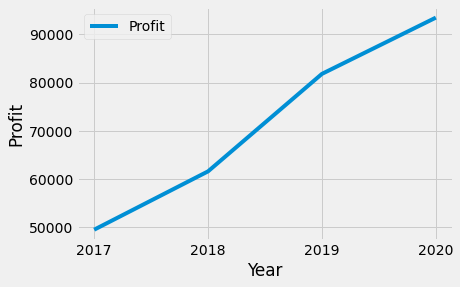

In [15]:
pd.pivot_table(df_orders,values=['Profit'], index='order_year', aggfunc= {'Profit': 'sum'}).plot(xlabel='Year',ylabel='Profit').locator_params(integer=True)   

# b. KPI Outcome: Ship Mode Profit per Year

In [16]:
pd.pivot_table(df_orders, columns='Ship Mode',values=['Profit'], index='order_year', aggfunc= {'Profit': 'sum'})  

Profit                    
Ship Mode    Express Standard Processing
order_year                              
2017       11,829.04           37,714.93
2018       14,473.87           47,144.74
2019       14,796.30           66,998.88
2020       23,762.39           69,676.88

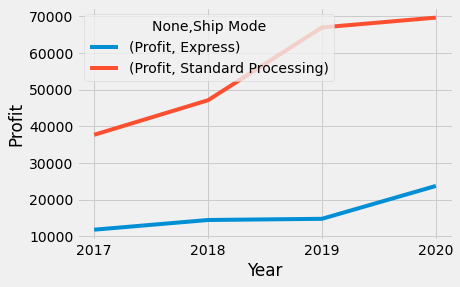

In [17]:
pd.pivot_table(df_orders, columns='Ship Mode',values=['Profit'], index=['order_year'], aggfunc= {'Profit': 'sum'}).plot(xlabel='Year',ylabel='Profit').locator_params(integer=True) 

# c. Internal Process: Check Average Time for each Ship Mode per Day of Week

In [18]:
df_orders.head(2)

,Order ID,Order Date,Ship Mode,Customer ID,Customer Name,Sales,Profit,order_year,order_weekday
0,CA-2019-121755,2019-01-16,Standard Processing,EH-13945,Eric Hoffmann,90.57,11.77,2019,2
1,CA-2019-118255,2019-03-11,Express,ON-18715,Odella Nelson,45.98,19.77,2019,0


In [19]:
df_process.head(2)

,Row ID,Order ID,Order Date,On Truck Scan Date,Ship Mode,order_weekday,truck_weekday
0,"3,074.00",CA-2019-125206,2019-01-03,2019-01-07,Express,3,0
1,"4,919.00",CA-2019-160304,2019-01-02,2019-01-09,Standard Processing,2,2


In [20]:
df_process.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5899 entries, 0 to 5898
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Row ID              5899 non-null   float64       
 1   Order ID            5899 non-null   object        
 2   Order Date          5899 non-null   datetime64[ns]
 3   On Truck Scan Date  5899 non-null   datetime64[ns]
 4   Ship Mode           5899 non-null   object        
 5   order_weekday       5899 non-null   int64         
 6   truck_weekday       5899 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(2)
memory usage: 322.7+ KB


Clean up column names that contain whitespace.

In [21]:
df_process.columns = df_process.columns.str.replace(' ', '_')
df_process.head(2)

,Row_ID,Order_ID,Order_Date,On_Truck_Scan_Date,Ship_Mode,order_weekday,truck_weekday
0,"3,074.00",CA-2019-125206,2019-01-03,2019-01-07,Express,3,0
1,"4,919.00",CA-2019-160304,2019-01-02,2019-01-09,Standard Processing,2,2


In [22]:
df_process.isnull().sum()

Row_ID                0
Order_ID              0
Order_Date            0
On_Truck_Scan_Date    0
Ship_Mode             0
order_weekday         0
truck_weekday         0
dtype: int64

Now I will calculate the numbers of days between the day of the order and the day of loading the order in the truck. This data we can find only in the 'process dataset'.

In [23]:
df_process['days_in_warehouse'] = (df_process['On_Truck_Scan_Date'] - df_process['Order_Date']).dt.days
df_process.columns

Index(['Row_ID', 'Order_ID', 'Order_Date', 'On_Truck_Scan_Date', 'Ship_Mode',
       'order_weekday', 'truck_weekday', 'days_in_warehouse'],
      dtype='object')

In [24]:
df_process['Ship_Mode'].value_counts()

Standard Processing    4596
Express                1303
Name: Ship_Mode, dtype: int64

In [25]:
df_process.head(2)

,Row_ID,Order_ID,Order_Date,On_Truck_Scan_Date,Ship_Mode,order_weekday,truck_weekday,days_in_warehouse
0,"3,074.00",CA-2019-125206,2019-01-03,2019-01-07,Express,3,0,4
1,"4,919.00",CA-2019-160304,2019-01-02,2019-01-09,Standard Processing,2,2,7


In [26]:
df_process['Row_ID'].duplicated().value_counts()

False    5899
Name: Row_ID, dtype: int64

In [27]:
df_process['Order_ID'].duplicated().value_counts()

False    3002
True     2897
Name: Order_ID, dtype: int64

I will keep the duplicates since each Row_ID is for a single product, but a Order_ID could have more products.

Since the warehouse is not working in weekends, now I will calculate the number of working days necessary for each order to be ready for shipping.

In [28]:
A = [d.date() for d in df_process['Order_Date']]
B = [d.date() for d in df_process['On_Truck_Scan_Date']]
df_process['Weekdays_in_Warehouse'] = np.busday_count(A, B)
df_process.head(2)

,Row_ID,Order_ID,Order_Date,On_Truck_Scan_Date,Ship_Mode,order_weekday,truck_weekday,days_in_warehouse,Weekdays_in_Warehouse
0,"3,074.00",CA-2019-125206,2019-01-03,2019-01-07,Express,3,0,4,2
1,"4,919.00",CA-2019-160304,2019-01-02,2019-01-09,Standard Processing,2,2,7,5


In [29]:
days = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
df_process['order_weekday'] = df_process['order_weekday'].apply(lambda x: days[x])

In [30]:
df_process.groupby('Weekdays_in_Warehouse')

Now I will group the processing by how many workdays are needed to make the orders ready for shipping and loaded in the truck.

In [31]:
groupby_obj = df_process.groupby('Weekdays_in_Warehouse')
groupby_obj.mean()

,Row_ID,truck_weekday,days_in_warehouse
Weekdays_in_Warehouse,,,
0,"5,679.95",1.60,0.28
1,"4,784.52",1.94,1.73
2,"4,828.21",1.89,3.12
3,"5,092.70",2.12,4.43
4,"5,119.74",2.61,5.58
5,"5,088.45",1.75,7.22
6,"4,675.01",2.23,8.14
7,"5,215.68",2.23,9.38
8,"5,370.90",3.30,10.20


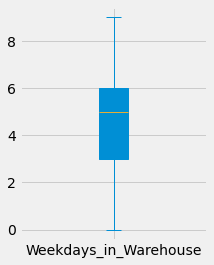

In [32]:
plt.figure(figsize=(3,4))
df_process['Weekdays_in_Warehouse'].plot(kind='box', patch_artist=True);

In [33]:
groupby_obj.count()

,Row_ID,Order_ID,Order_Date,On_Truck_Scan_Date,Ship_Mode,order_weekday,truck_weekday,days_in_warehouse
Weekdays_in_Warehouse,,,,,,,,
0,193,193,193,193,193,193,193,193
1,350,350,350,350,350,350,350,350
2,526,526,526,526,526,526,526,526
3,687,687,687,687,687,687,687,687
4,1041,1041,1041,1041,1041,1041,1041,1041
5,1385,1385,1385,1385,1385,1385,1385,1385
6,961,961,961,961,961,961,961,961
7,729,729,729,729,729,729,729,729
8,10,10,10,10,10,10,10,10


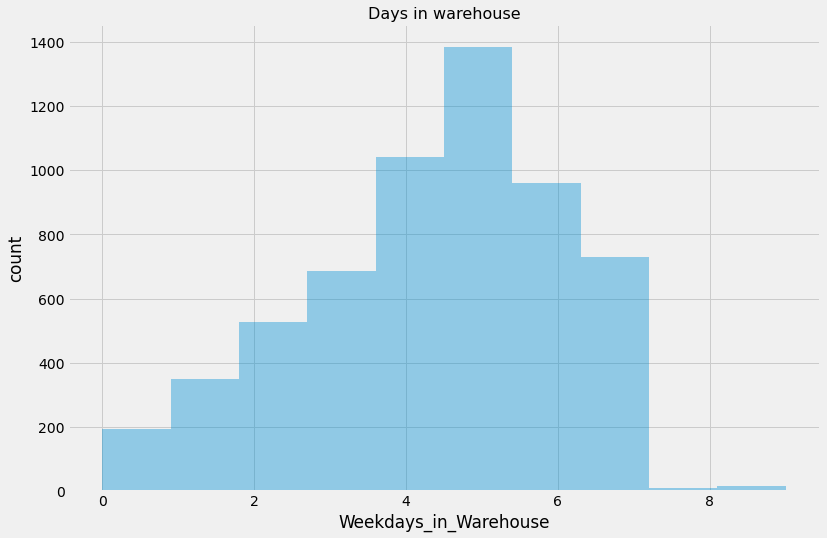

In [34]:
plt.figure(figsize=(12,8))
sns.distplot(df_process['Weekdays_in_Warehouse'], kde=False, hist=True, bins=10)
plt.title('Days in warehouse', size=16)
plt.ylabel('count');

As you can see in the above plot, 1385 of the orders were processing by the warehouse in 5 days, 1041 in 4 days and 961 in 6 days.

In [35]:
Internal_process_KPI = pd.pivot_table(df_process,
                                    values='Weekdays_in_Warehouse',
                                    index='Ship_Mode',
                                    aggfunc={'Weekdays_in_Warehouse': np.mean},
                                    columns='order_weekday'
                                    )
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
Internal_process_KPI.columns = pd.CategoricalIndex(Internal_process_KPI.columns, categories=cats, ordered=True)
Internal_process_KPI=Internal_process_KPI.sort_index(axis=1)
Internal_process_KPI

order_weekday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Ship_Mode,,,,,,,
Express,2.09,2.12,1.93,1.56,0.82,2.60,2.00
Standard Processing,5.95,5.64,5.02,4.49,4.14,3.49,5.91


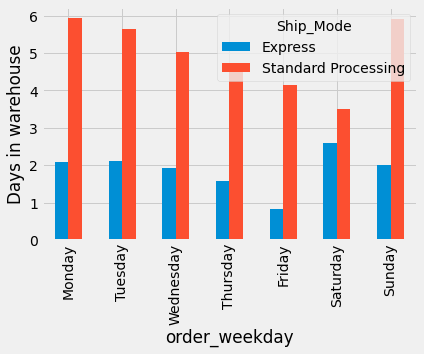

In [36]:
ax = Internal_process_KPI.T.plot(kind='bar', ylabel='Days in warehouse');

As we can see from the graphic, the numbers of days necessary for processing the orders in the warehouse is decreasing from Monday till Friday, but because the warehouse is closed in the weekend, but the clients can order, so on Monday the number of orders is too big to be handled in time. So we found the bottleneck in the warehouse process and we will come back to it in the Recommendation Section.

# d. External process: check average delivery time of the Logistic Company

In [37]:
df_intern.columns = df_intern.columns.str.replace(' ', '_')
df_intern.head(2)

,Order_ID,Ready_to_Ship_Date,Pickup_Date
0,CA-2019-116540,2019-09-02,2019-09-03
1,CA-2019-116540,2019-09-02,2019-09-03


In [38]:
df_intern.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Order_ID            290 non-null    object        
 1   Ready_to_Ship_Date  290 non-null    datetime64[ns]
 2   Pickup_Date         290 non-null    datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 6.9+ KB


In [39]:
df_intern.Order_ID.duplicated().sum()

86

In [40]:
df_intern.drop_duplicates(inplace=True)
df_intern.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 0 to 289
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Order_ID            204 non-null    object        
 1   Ready_to_Ship_Date  204 non-null    datetime64[ns]
 2   Pickup_Date         204 non-null    datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 6.4+ KB


In [46]:
df_intern.reset_index(inplace=True)

In [50]:
df_campaign.head(2)

,Order ID,Arrival Scan Date,Customer Name
0,CA-2019-109666,2019-05-03,Kunst Miller
1,CA-2019-138933,2019-05-03,Jack Lebron


In [51]:
df_campaign.columns = df_campaign.columns.str.replace(' ', '_')
df_campaign.head(2)

,Order_ID,Arrival_Scan_Date,Customer_Name
0,CA-2019-109666,2019-05-03,Kunst Miller
1,CA-2019-138933,2019-05-03,Jack Lebron


In [52]:
df_campaign.Order_ID.duplicated().sum()

0

In [53]:
df_campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Order_ID           333 non-null    object        
 1   Arrival_Scan_Date  333 non-null    datetime64[ns]
 2   Customer_Name      333 non-null    object        
dtypes: datetime64[ns](1), object(2)
memory usage: 7.9+ KB


In order to calculate the number of days necessary for the Logistic Company to deliver the orders, I will join the campaign dataset with the intern datasets over the 'Order_ID' column.

In [54]:
merge_df = df_campaign.merge(df_intern, on='Order_ID')
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 0 to 21
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Order_ID            22 non-null     object        
 1   Arrival_Scan_Date   22 non-null     datetime64[ns]
 2   Customer_Name       22 non-null     object        
 3   index               22 non-null     int64         
 4   Ready_to_Ship_Date  22 non-null     datetime64[ns]
 5   Pickup_Date         22 non-null     datetime64[ns]
dtypes: datetime64[ns](3), int64(1), object(2)
memory usage: 1.2+ KB


The joined dataset consists only of 22 entries, so we could say that it is a rather small sample.

In [55]:
merge_df.head(2)

,Order_ID,Arrival_Scan_Date,Customer_Name,index,Ready_to_Ship_Date,Pickup_Date
0,CA-2019-129630,2019-09-09,Ionia McGrath,3,2019-09-04,2019-09-04
1,CA-2019-129847,2019-09-10,Tom Ashbrook,2,2019-09-04,2019-09-04


Next I will calculate the days necessary for the Logistic Company to deliver the orders. Since they are not delivering the orders in weekend, I will calculate only the working days.

In [56]:
A = [d.date() for d in merge_df['Pickup_Date']]
B = [d.date() for d in merge_df['Arrival_Scan_Date']]
merge_df['delivery_days'] = np.busday_count(A, B)
merge_df.head(2)

,Order_ID,Arrival_Scan_Date,Customer_Name,index,Ready_to_Ship_Date,Pickup_Date,delivery_days
0,CA-2019-129630,2019-09-09,Ionia McGrath,3,2019-09-04,2019-09-04,3
1,CA-2019-129847,2019-09-10,Tom Ashbrook,2,2019-09-04,2019-09-04,4


In [57]:
merge_df['delivery_days'].mean()

2.772727272727273

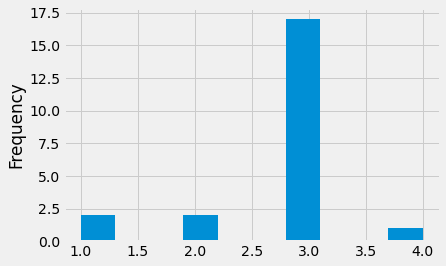

In [59]:
merge_df['delivery_days'].plot(kind='hist');

The Logistic Company stated that they will deliver the orders in average in 3 days; from my calculus, the average delivery time is 2.77 days, so I can say that they are respecting the commitment. As you could see from the graphic, they exceeded the 3 days only ones in 22 deliveries, so we could say that they respected the promise in 95.5 % of the deliveries.

# e. Internal Process: Impact of Day of the Order on Delivery Time

Since I didn't have any direct data to cover all the process from the day of the order till the day of the delivery, I will merge and join 3 datasets to calculate the number of days in which the client receives the product ordered and I will try to see if the day of the week in which the client sends the order matter.


In [62]:
df_orders.columns = df_orders.columns.str.replace(' ', '_')
df_orders.head(2)

,Order_ID,Order_Date,Ship_Mode,Customer_ID,Customer_Name,Sales,Profit,order_year,order_weekday
0,CA-2019-121755,2019-01-16,Standard Processing,EH-13945,Eric Hoffmann,90.57,11.77,2019,2
1,CA-2019-118255,2019-03-11,Express,ON-18715,Odella Nelson,45.98,19.77,2019,0


In [63]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order_ID       9994 non-null   object        
 1   Order_Date     9994 non-null   datetime64[ns]
 2   Ship_Mode      9994 non-null   object        
 3   Customer_ID    9994 non-null   object        
 4   Customer_Name  9994 non-null   object        
 5   Sales          9994 non-null   float64       
 6   Profit         9994 non-null   float64       
 7   order_year     9994 non-null   int64         
 8   order_weekday  9994 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 702.8+ KB


In [64]:
df_campaign.head(2)

,Order_ID,Arrival_Scan_Date,Customer_Name
0,CA-2019-109666,2019-05-03,Kunst Miller
1,CA-2019-138933,2019-05-03,Jack Lebron


In [65]:
df_campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Order_ID           333 non-null    object        
 1   Arrival_Scan_Date  333 non-null    datetime64[ns]
 2   Customer_Name      333 non-null    object        
dtypes: datetime64[ns](1), object(2)
memory usage: 7.9+ KB


In [66]:
merged_df = df_orders.merge(df_campaign, on='Order_ID')
merged_df.head(2)

,Order_ID,Order_Date,Ship_Mode,Customer_ID,Customer_Name_x,Sales,Profit,order_year,order_weekday,Arrival_Scan_Date,Customer_Name_y
0,CA-2019-145625,2019-09-11,Standard Processing,KC-16540,Kelly Collister,"3,347.37",636.00,2019,2,2019-09-23,Kelly Collister
1,CA-2019-145625,2019-09-11,Standard Processing,KC-16540,Kelly Collister,7.61,3.58,2019,2,2019-09-23,Kelly Collister


In [67]:
merged_df.describe()

,Sales,Profit,order_year,order_weekday
count,668.00,668.00,668.00,668.00
mean,245.65,38.89,"2,019.18",2.80
std,865.21,389.98,0.39,2.01
min,0.56,"-3,399.98","2,019.00",0.00
25%,15.53,1.64,"2,019.00",1.00
50%,48.32,8.54,"2,019.00",3.00
75%,192.45,25.84,"2,019.00",4.00
max,"17,499.95","8,399.98","2,020.00",6.00


In [68]:
merged_df['delivery_days'] = (merged_df['Arrival_Scan_Date'] - merged_df['Order_Date']).dt.days
merged_df.head(2)

,Order_ID,Order_Date,Ship_Mode,Customer_ID,Customer_Name_x,Sales,Profit,order_year,order_weekday,Arrival_Scan_Date,Customer_Name_y,delivery_days
0,CA-2019-145625,2019-09-11,Standard Processing,KC-16540,Kelly Collister,"3,347.37",636.00,2019,2,2019-09-23,Kelly Collister,12
1,CA-2019-145625,2019-09-11,Standard Processing,KC-16540,Kelly Collister,7.61,3.58,2019,2,2019-09-23,Kelly Collister,12


In [69]:
merged_df['Order_ID'].nunique()

333

In [71]:
merged_df.drop_duplicates('Order_ID',keep=False, inplace=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171 entries, 4 to 667
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Order_ID           171 non-null    object        
 1   Order_Date         171 non-null    datetime64[ns]
 2   Ship_Mode          171 non-null    object        
 3   Customer_ID        171 non-null    object        
 4   Customer_Name_x    171 non-null    object        
 5   Sales              171 non-null    float64       
 6   Profit             171 non-null    float64       
 7   order_year         171 non-null    int64         
 8   order_weekday      171 non-null    int64         
 9   Arrival_Scan_Date  171 non-null    datetime64[ns]
 10  Customer_Name_y    171 non-null    object        
 11  delivery_days      171 non-null    int64         
dtypes: datetime64[ns](2), float64(2), int64(3), object(5)
memory usage: 17.4+ KB


In [72]:
merged_df.describe()

,Sales,Profit,order_year,order_weekday,delivery_days
count,171.00,171.00,171.00,171.00,171.00
mean,188.38,17.34,"2,019.12",2.64,10.85
std,365.41,129.72,0.33,2.07,2.75
min,0.56,"-1,141.47","2,019.00",0.00,3.00
25%,14.93,1.63,"2,019.00",1.00,9.00
50%,43.60,8.62,"2,019.00",3.00,11.00
75%,175.56,23.97,"2,019.00",4.00,13.00
max,"2,396.40",899.98,"2,020.00",6.00,16.00


In [73]:
merged_df.drop(['Order_Date', 'Customer_Name_x','Profit', 'Sales', 'order_year', 'order_weekday', 'Customer_Name_y'], axis=1, inplace=True)
merged_df.head(2)

,Order_ID,Ship_Mode,Customer_ID,Arrival_Scan_Date,delivery_days
4,CA-2019-169166,Standard Processing,SS-20590,2019-05-20,11
13,CA-2019-168081,Standard Processing,CA-12055,2019-05-06,12


In [76]:
df_orders.drop(["Ship_Mode", "Customer_ID", "Customer_Name", "Sales", "Profit"], axis=1, inplace=True)
df_orders.head(1)

,Order_ID,Order_Date,order_year,order_weekday
0,CA-2019-121755,2019-01-16,2019,2


In [77]:
join_df = df_orders.join(merged_df.set_index('Order_ID'), on='Order_ID')
join_df.head(2)

,Order_ID,Order_Date,order_year,order_weekday,Ship_Mode,Customer_ID,Arrival_Scan_Date,delivery_days
0,CA-2019-121755,2019-01-16,2019,2,NaN,NaN,NaT,NaN
1,CA-2019-118255,2019-03-11,2019,0,NaN,NaN,NaT,NaN


In [79]:
join_df.drop(["Ship_Mode", "Customer_ID", "Arrival_Scan_Date"], axis=1, inplace=True)
join_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order_ID       9994 non-null   object        
 1   Order_Date     9994 non-null   datetime64[ns]
 2   order_year     9994 non-null   int64         
 3   order_weekday  9994 non-null   int64         
 4   delivery_days  171 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 390.5+ KB


Since I didn't have enough data, I simulated them to populate the delivery_days column

In [80]:
join_df['delivery_days'] = join_df['delivery_days'].apply(lambda x: np.random.choice(join_df['delivery_days'].dropna().values) if np.isnan(x) else x)

In [81]:
join_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order_ID       9994 non-null   object        
 1   Order_Date     9994 non-null   datetime64[ns]
 2   order_year     9994 non-null   int64         
 3   order_weekday  9994 non-null   int64         
 4   delivery_days  9994 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 390.5+ KB


In [83]:
join_df.describe()

,order_year,order_weekday,delivery_days
count,"9,994.00","9,994.00","9,994.00"
mean,"2,018.72",2.64,10.89
std,1.12,1.81,2.70
min,"2,017.00",0.00,3.00
25%,"2,018.00",1.00,9.00
50%,"2,019.00",3.00,11.00
75%,"2,020.00",4.00,13.00
max,"2,020.00",6.00,16.00


In [82]:
join_df.delivery_days.quantile(0.95)

15.0

As you could see above, the average days necessary for an order to be delivered is 10.89 days. Also, 15 is the number of days necessary for 95% of orders to be delivered.

In [84]:
#Orders received on Monday
join_df[join_df['order_weekday'] == 0].describe()

,order_year,order_weekday,delivery_days
count,"1,408.00","1,408.00","1,408.00"
mean,"2,019.04",0.00,10.83
std,0.90,0.00,2.64
min,"2,017.00",0.00,3.00
25%,"2,018.00",0.00,9.00
50%,"2,019.00",0.00,11.00
75%,"2,020.00",0.00,13.00
max,"2,020.00",0.00,16.00


In [85]:
##Orders received on Tuesday
join_df[join_df['order_weekday'] == 1].describe()

,order_year,order_weekday,delivery_days
count,"1,783.00","1,783.00","1,783.00"
mean,"2,018.72",1.00,10.87
std,1.14,0.00,2.72
min,"2,017.00",1.00,3.00
25%,"2,018.00",1.00,9.00
50%,"2,019.00",1.00,11.00
75%,"2,020.00",1.00,13.00
max,"2,020.00",1.00,16.00


In [86]:
##Orders received on Wednesday
join_df[join_df['order_weekday'] == 2].describe()

,order_year,order_weekday,delivery_days
count,"1,706.00","1,706.00","1,706.00"
mean,"2,018.77",2.00,10.87
std,1.12,0.00,2.78
min,"2,017.00",2.00,3.00
25%,"2,018.00",2.00,9.00
50%,"2,019.00",2.00,11.00
75%,"2,020.00",2.00,13.00
max,"2,020.00",2.00,16.00


In [87]:
##Orders received on Thursday
join_df[join_df['order_weekday'] == 3].describe()

,order_year,order_weekday,delivery_days
count,"1,736.00","1,736.00","1,736.00"
mean,"2,018.77",3.00,10.93
std,1.08,0.00,2.62
min,"2,017.00",3.00,3.00
25%,"2,018.00",3.00,9.75
50%,"2,019.00",3.00,11.00
75%,"2,020.00",3.00,13.00
max,"2,020.00",3.00,16.00


In [88]:
##Orders received on Friday
join_df[join_df['order_weekday'] == 4].describe()

,order_year,order_weekday,delivery_days
count,"1,648.00","1,648.00","1,648.00"
mean,"2,018.65",4.00,10.83
std,1.20,0.00,2.72
min,"2,017.00",4.00,3.00
25%,"2,018.00",4.00,9.00
50%,"2,019.00",4.00,11.00
75%,"2,020.00",4.00,13.00
max,"2,020.00",4.00,16.00


In [89]:
##Orders received on Saturday
join_df[join_df['order_weekday'] == 5].describe()

,order_year,order_weekday,delivery_days
count,876.00,876.00,876.00
mean,"2,018.27",5.00,10.91
std,1.26,0.00,2.72
min,"2,017.00",5.00,3.00
25%,"2,017.00",5.00,9.00
50%,"2,018.00",5.00,11.00
75%,"2,020.00",5.00,13.00
max,"2,020.00",5.00,16.00


In [90]:
##Orders received on Sunday
join_df[join_df['order_weekday'] == 6].describe()

,order_year,order_weekday,delivery_days
count,837.00,837.00,837.00
mean,"2,018.61",6.00,11.04
std,1.02,0.00,2.73
min,"2,017.00",6.00,3.00
25%,"2,017.00",6.00,9.00
50%,"2,019.00",6.00,11.00
75%,"2,019.00",6.00,13.00
max,"2,020.00",6.00,16.00


As you can see, the day of the order doesn't really matter, since the average number of days necessary for an order to be delivered to the client is between 10.68 and 10.94.